### Page Replacement Algorithms:

There are different page replacement algorithms and yet there seems to be some drawbacks in them, making no page replacement algorithm ideal. To be one step closer to achieving the ideal algorithm it is vital to have a maximum cache hit ratio and strong consistent across different workload.

In [8]:
from tqdm import tqdm_notebook as tqdm 
import numpy as np
from collections import deque, defaultdict

### Optimal Page replacement algorithm:
The OPT algorithm is a theoretical concept which evicts the block from the cache based on future access predictions of the blocks present in the cache, this algorithm is hard to achieve as future predictions on the access can not be determined.

In [9]:
#finding the block which is avaialble in future
def findfar(blk, frm):
    farthest = 0
    far_ind = {}
    nomore = []
    for v in frm:
        if v not in blk:
            far_ind[v] = -1
        elif v in blk:
            far_ind[v] = blk.index(v)
    srtdlst = sorted(far_ind.items(), key=lambda item:item[1], reverse= True)

    for (k,v) in srtdlst:
        if v == -1:
            nomore.append(k)
    if nomore:
        return nomore[0]
    else:
        return srtdlst[0][0]
    

In [10]:
#Offline optimal page replacemnt algorithm
def OPT(blk,size):
    frame = set()
    hits = 0
    misses = 0
    isfull = False
    
    for i,b in enumerate(blk):
        
        if b not in frame:
            misses += 1

            if len(frame) == size:
                isfull = True
            if not isfull:
                frame.add(b)
            else:
                farthest = findfar(blk[i+1:], frame)
                frame.discard(farthest)
                frame.add(b)
        else:
            hits += 1
    return hits/(hits+misses)



### LRU(Least Recently Used) Page replacement algorithm
The simplest algorithm used to manage the cache data is the LRU.
The LRU algorithm ensures that when a block present in the cache is accessed the block is moved to the top of the stack. When block not present in the cache is accessed, the newly accessed block takes the place of the least recent block in the cache.

In [11]:
def LRU(blocktrace, frame):
    
    cache = set()
    recency = deque()
    hit, miss = 0, 0
    
    for block in tqdm(blocktrace, leave=False):
        
        if block in cache:
            recency.remove(block)
            recency.append(block)
            hit += 1
            
        elif len(cache) < frame:
            cache.add(block)
            recency.append(block)
            miss += 1
            
        else:
            cache.remove(recency[0])
            recency.popleft()
            cache.add(block)
            recency.append(block)
            miss += 1
    
    hitrate = hit / (hit + miss)
    return hitrate

### LFU(Least frequently used) Page replacement algortihm:
In contrast to the LRU algorithm, this algorithm computes the frequency of access for every block. When the block present in the cache is accessed the block’s frequency will increase, when a block not present in the cache is accessed then the newly accessed block replaces the least frequency block in the cache.

In [12]:
def LFU(blocktrace, frame):
    
    cache = set()
    cache_frequency = defaultdict(int)
    frequency = defaultdict(int)
    
    hit, miss = 0, 0
    
    for block in tqdm(blocktrace):
        frequency[block] += 1
        
        if block in cache:
            hit += 1
            cache_frequency[block] += 1
        
        elif len(cache) < frame:
            cache.add(block)
            cache_frequency[block] += 1
            miss += 1

        else:
            
            e, f = min(cache_frequency.items(), key=lambda a: a[1])
            cache_frequency.pop(e)
            cache.remove(e)
            cache.add(block)
            cache_frequency[block] = frequency[block]
            miss += 1
    
    hitrate = hit / ( hit + miss )
    return hitrate

### DAS (Dynamic And Stable) Page Replacement Algorithm:
This algorithm has achieved consistent hit ratio by using the fundamentals of page replacement algorithm which are: low recency and high frequency of the blocks. To achieve this stability we have to integrate the design principles of LRU and LFU in the cache and the blocks have been placed blocks according to the hit on the block, the above mentioned is done using simple computations.

In [13]:
def DAS(block, frame):
    
    #set frames of two cache
    LRUframe=int(0.1 * frame)
    LFUframe= frame - LRUframe
    
    #initial declare of hit and miss
    hit,miss,LRU_hit, LFU_hit=0,0,0,0
    
    #inital set declare for LRU and LFU
    LRUcache= deque()
    LFUcache= deque()

    LFU_cache_frequency = defaultdict(int)
    frequency = defaultdict(int)
    LRU_cache_frequency = defaultdict(int)
    
    for block in tqdm(block):
        frequency[block] += 1
        if block in LRUcache or block in LFUcache:
            hit+=1
            #checked
            if block in LFUcache:
                LFU_hit +=1
                LFU_cache_frequency[block] += 1
               
            if block in LRUcache:
                LRU_hit +=1
                LRU_cache_frequency[block] += 1
                
                #checked
                if len(LFUcache) < LFUframe:
                    
                    LRUcache.remove(block)
                    LFUcache.append(block)
                    LFU_cache_frequency[block] = LRU_cache_frequency[block]
                    del LRU_cache_frequency[block]
                    
                else: 
                    #block, frequency
                    e, LFU_fre = min(LFU_cache_frequency.items(), key=lambda a: a[1])
                    #print(e, LFU_fre)
                    LRUcache.remove(block)
                    LFUcache.append(block)
                    LFU_cache_frequency[block] = LRU_cache_frequency[block]
                    del LRU_cache_frequency[block]
                    
                    LFUcache.remove(e)
                    LRUcache.append(e)
                    LRU_cache_frequency[e] = LFU_fre
                    del LFU_cache_frequency[e]

        elif (len(LRUcache) + len(LFUcache)) < frame:
            miss += 1
        #first i will fill LRU block 
            if len(LRUcache) <= LRUframe-1:
                LRUcache.append(block)
                LRU_cache_frequency[block] += 1
                #print("LRUcache", LRUcache)
            else:
             #now if recent clock
                if len(LFUcache) <= LFUframe-1:
                    LFU_cache_frequency[block] += 1
                    LFUcache.append(block)
        else:
            #adding miss block in cache
            miss += 1
            #print(len(LFUcache), len(LRUcache))
            old = LRUcache.popleft()
            LRUcache.append(block)
            del LRU_cache_frequency[old]
            LRU_cache_frequency[block] = frequency[block]
            
    hitrate = hit /(hit+ miss)
    return hitrate
   

In [14]:
import pandas as pd
DAS_hit =[]
LRU_hit = []
LFU_hit = []
OPT_hit = []

size = [30,60,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400] 

for i in range(len(size)):
    f = open("cs.trc", 'r')
    DAS_hit.append(round(DAS(f,size[i])*100 ,2))                                                                
dict = {'x': size, 'y': DAS_hit}     # dictionary of lists      
DAS_df = pd.DataFrame(dict)          #print(dict)
DAS_df.to_csv('cs_DAS.csv')     # saving the dataframe 

for i in range(len(size)):
    f = open("cs.trc", 'r')
    LRU_hit.append(round(LRU(f,size[i])*100 ,2))                                                                
dict = {'x': size, 'y': LRU_hit}     # dictionary of lists      
LRU_df = pd.DataFrame(dict)          #print(dict)
LRU_df.to_csv('cs_LRU.csv')     # saving the dataframe 

for i in range(len(size)):
    f = open("cs.trc", 'r')
    LFU_hit.append(round(LFU(f,size[i])*100 ,2))                                                                
dict = {'x': size, 'y': LFU_hit}     # dictionary of lists      
LFU_df = pd.DataFrame(dict)          #print(dict)
LFU_df.to_csv('cs_LFU.csv')     # saving the dataframe 

for i in range(len(size)):
    #f = open("test.txt", 'r')
    lineList = [line.rstrip('\n') for line in open("cs.trc")]
    OPT_hit.append(round(OPT(lineList,size[i])*100 ,2))
#print(hit)
   # dictionary of lists  
dict = {'x': size, 'y': OPT_hit}  
     
OPT_df = pd.DataFrame(dict) 
  
# saving the dataframe 
OPT_df.to_csv('cs_OPT.csv')


### Experiment 3 with traces "cs" is an interactive C source program examination tool trace. The total size of the C programs used as input is roughly 9 MB.

In the looping pattern, recency predicts the opposite of the future reference time of a block: the larger the recency of a block is, the sooner the block will be re-referenced. The hit rate of LRU for cs is almost 0% until the cache size approaches 1,400 blocks, which can hold all the blocks referenced in the loop.


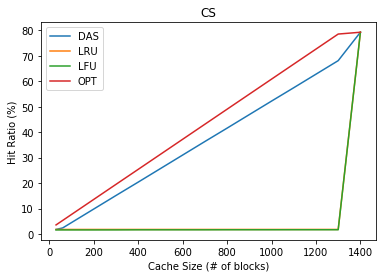

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

DAS =pd.read_csv('cs_DAS.csv')
LRU =pd.read_csv('cs_LRU.csv')
LFU =pd.read_csv('cs_LFU.csv')
OPT =pd.read_csv('cs_OPT.csv')
plt.plot(DAS['x'], DAS['y'], label="DAS")
plt.plot(LRU['x'], LRU['y'], label="LRU")
plt.plot(LFU['x'], LFU['y'], label="LFU")
plt.plot(OPT['x'], OPT['y'], label="OPT")

plt.title("CS")
plt.xlabel('Cache Size (# of blocks)')
plt.ylabel('Hit Ratio (%)')
plt.legend()